# Chapter 3: Building the Full GPT Model

<div class="alert alert-block alert-success">

In the previous chapters, we built the core components of a transformer, most importantly the `MultiHeadAttention` module. Now, it's time to assemble these pieces into a complete, functional GPT model.

Our approach will be "top-down." First, we will define the high-level architecture of the entire model using simple placeholders for the complex parts. This will help us understand the overall data flow. 
Then, in the following sections, we will build the real components to replace these placeholders one by one.
</div>

## 3.1 Imports and Setup

<div class="alert alert-block alert-success">
As always, we begin by importing the necessary libraries.
</div>

In [3]:
# Standard library and third-party imports
import sys
import os
import torch
import torch.nn as nn
import tiktoken

import matplotlib.pyplot as plt

# --- Add Project Root to Python Path ---

# Get the directory of the current notebook
current_notebook_dir = os.getcwd()

# Go up one level to the project's root directory
project_root = os.path.abspath(os.path.join(current_notebook_dir, '..'))

# Add the project root to the Python path if it's not already there
if project_root not in sys.path:
    sys.path.append(project_root)

# --- Imports from your `src` package ---
from src.attention import MultiHeadAttention
# from gpt_from_scratch.layers import LayerNorm, FeedForward, GELU

## 3.2 Model Configuration

<div class="alert alert-block alert-success">
First, let's define a configuration dictionary that will hold all the hyperparameters for our model. We will base this on the parameters of the original GPT-2 "small" model, which has 124 million parameters.
</div>

In [11]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "dropout_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias in attention
}

## 3.3 The GPT Architecture I: A High Level View

<div class="alert alert-block alert-success">
<div class="alert alert-block alert-info">
    
  <b>A "Top-Down" Approach</b><br>
    
Before we assemble the final, complex components of our GPT model, it's helpful to first understand the big picture. In this section, we'll adopt a **"top-down"** design approach by building a high-level **"skeleton"** of the entire model.
</div>
    

We will use simple dummy classes as placeholders for the internal machinery, like the `TransformerBlock` and `LayerNorm`. This strategy allows us to focus on the overall architecture and trace the journey of a tensor as it flows from the input embedding layer to the final output logits, ensuring our high-level structure is correct before we dive into implementing the details.
</div>

### 3.3.1 Defining the Model Skeleton

<div class="alert alert-block alert-success">

The code below defines our `DummyGPTModel`. It includes the complete end-to-end structure of the network. Notice the placeholder classes, `DummyTransformerBlock` and `DummyLayerNorm`, which are designed to simply pass the input through without any changes for now.
</div>

In [3]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["dropout_rate"])

        # Use a placeholder for the stack of Transformer Blocks
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        # Use a placeholder for the final LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits        


# --- Placeholder Classes ---

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
    def forward(self, x):
        # This block does nothing and just returns its input
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
    def forward(self, x):
        # This layer also does nothing and just returns its input
        return x
    

<div class="alert alert-block alert-warning">

The `DummyGPTModel` defines the complete, high-level architecture. Let's analyze the `forward` method to understand the data flow:

1. **Embedding:** The input token IDs are converted into token embeddings. Simultaneously, positional embeddings are created for each token based on its position in the sequence. These two embeddings are added together to give each token semantic meaning and positional context.
   
2. **Transformer Blocks:** The resulting embeddings are processed through a stack of `n_layers` Transformer blocks. In this dummy version, these blocks don't do anything yet, but this is where the self-attention and feed-forward logic will go.

3. **Final Normalization:** A final `LayerNorm` is applied after the Transformer Blocks.

4. **Output Head:** A final linear layer projects the output of the transformers back into vocabulary space, producing raw, unnormalized scores (logits) for every possible token in the vocabulary.

Now that we have this high-level skeleton, the next sections will focus on building the real, functional version of `LayerNorm` and `TransformerBlock` to replace these placeholders.

</div>

### 3.3.2 Testing the GPT Model Skeleton

<div class="alert alert-block alert-success">
    
Now that we have the high-level skeleton of our model, let's run a quick test to ensure the data flows through it correctly. We will perform two steps:
    
* 1.  First, we'll tokenize two sample sentences and create an input batch.
* 2.  Second, we'll pass this batch through our `DummyGPTModel` and verify that the output tensor has the shape we expect.
</div>

In [9]:
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print("Input shape:", batch.shape)
print(batch)

Input shape: torch.Size([2, 4])
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [5]:
# Create an instance of the DummyGPTModel
torch.manual_seed(100)
model = DummyGPTModel(GPT_CONFIG_124M)

# Pass the batch through the model
logits = model(batch)

# Print the shape of the output
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.1073, -0.3112,  0.4756,  ..., -0.0372,  1.4159,  0.0902],
         [-0.8873,  0.4433,  0.1565,  ..., -0.2307,  0.2448, -0.8779],
         [-2.3526, -0.9504, -0.7646,  ...,  0.7654,  0.2491,  0.3775],
         [ 0.5979,  1.0420, -1.5600,  ...,  0.4073, -0.0435, -0.3111]],

        [[-0.7754, -0.3975,  0.8207,  ..., -0.4550,  1.2873, -0.1645],
         [-1.2486, -0.1166,  0.6246,  ...,  0.5602,  0.8671, -0.6983],
         [-0.0773, -0.1393, -0.3316,  ..., -0.0703,  1.7652, -0.1684],
         [-0.1209,  0.4775,  0.3865,  ...,  0.4667, -1.6924, -0.4930]]],
       grad_fn=<UnsafeViewBackward0>)


### 3.3.3 Analyzing the Model's Output

<div class="alert alert-block alert-success">

The output of our model is a tensor of **logits** with the shape `[2, 4, 50257]`. Let's breakdown what each dimension represents:

* **`2` (Batch Size):** This corresponds to the two input sentences we provided ("Every effort moves you" and "Every day holds a").
* **`4` (Sequence Length):** This corresponds to the four tokens in each input sentence.
* **`50257` (Vocabulary Size):** For each of the 4 tokens in each sentence, the model has produced a vector of 50,257 raw, unnormalized scores. Each score corresponds to a unique token in the vocabulary.

These logits represent the model's raw "prediction" for the **next** token in the sequence at each position. Later, we will pass these logits through a softmax function to turn them into probabilities and generate text.

<div class="alert alert-block alert-info">
    
Now that we have successfully taken a top-down look at the GPT architecture and verified its data flow, we will begin coding the real components, starting with the `LayerNorm` class to replace `DummyLayerNorm`.
</div>    

</div>

## 3.4 The GPT Architecture II: Layer Normalization

<div class="alert alert-block alert-success">

Layer Normalization is a critical technique used in transformers to stabilize the training process. Deep neural networks can suffer from a problem where the distribution of activations changes between layers, making training difficult. Layer Normalization helps by re-centering and re-scaling the activations at each layer to a standard distribution (with a mean of 0 and a variance of 1).

</div>

### 3.4.1 Building LayerNorm from First Principles

<div class="alert alert-block alert-success">
To understand what Layer Normalization does, let's start with a simple example. We'll create a mini-batch of random data.
</div>

In [6]:
torch.manual_seed(100)

# Create a batch of 2 examples with 5 features each
batch_example = torch.randn(2, 5)

print(batch_example)

tensor([[ 0.3607, -0.2859, -0.3938,  0.2429, -1.3833],
        [-2.3134, -0.3172, -0.8660,  1.7482, -0.2759]])


<div class="alert alert-block alert-success">
<div class="alert alert-block alert-info">
    
As you can see, the output values are arbitrary. The purpose of LayerNorm is to rescale these activations.

</div>

Before we normalize, let's first calculate their current mean and variance for each example in the batch.

</div>

In [7]:
mean = batch_example.mean(dim=-1, keepdim=True)
var = batch_example.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Var:\n", var)

Mean:
 tensor([[-0.2919],
        [-0.4049]])
Var:
 tensor([[0.4784],
        [2.1288]])


<div class="alert alert-block alert-success">
Now for the core operation, Layer Normalization standardizes the activations by subtracting the mean and dividing by the standard deviation (the square root of the variance).
</div>

In [8]:
# Manually apply normalization
batch_norm = (batch_example - mean) / torch.sqrt(var)

print("Normalized batch:\n", batch_norm)

Normalized batch:
 tensor([[ 0.9435,  0.0086, -0.1474,  0.7733, -1.5780],
        [-1.3081,  0.0601, -0.3161,  1.4757,  0.0884]])


<div class="alert alert-block alert-success">
Let's verify the result. If the normalization worked, then the mean should be approximately 0 and the new variance should be 1. Note that the mean may not be exactly zero due to tiny floating-point inaccuracies.
</div>

In [9]:
# Verify the mean and variance of the normalized inputs
mean_norm = batch_norm.mean(dim=-1, keepdim=True)
var_norm = batch_norm.var(dim=-1, keepdim=True)

torch.set_printoptions(sci_mode=False)
print("Mean of normalized batch:\n", mean_norm)
print("Var of normalized batch:\n", var_norm)

Mean of normalized batch:
 tensor([[     0.0000],
        [    -0.0000]])
Var of normalized batch:
 tensor([[1.0000],
        [1.0000]])


### 3.4.2 Encapsulating the Logic in a `LayerNorm` Class

<div class="alert alert-block alert-success">
    
Now that we understood the step-by-step math, we can encapsulate this logic into a reusable PyTorch module. A production-ready `LayerNorm` class also includes two extra trainable parameters (`scale` and `shift`) and a small `epsilon` term for numerical stability.
</div>

In [19]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
        

<div class="alert alert-block alert-info">
    
<b>What do  `scale` and `shift` do?</b>

While forcing the activation to have a mean of 0 and variance of 1 is great for stability, it can sometimes limit the expressive power of the network. `scale` (gamma) and `shift` (beta) are trainable parameters that allow the model to learn the optimal scale and shift for the normalized activations. In essence , it gives the network the ability to "undo" the normalization if it finds that a different distribution works better for that specific layer.

<b>Note on `unbiased=False`</b>

In statistics, the variance of a sample is often calculated by dividing by `n-1` (unbiased) instead of `n` (biased). We explicitly set `unbiased=False`to divide by `n`. For the large embedding dimensions used in LLMs, the difference is negligible. This choice ensures  our implementation is compatible with the original GPT-2 model.

</div>

### 3.4.3 Testing the `LayerNorm` Class

<div class="alert alert-block alert-success">

Finally, let's instantiate our new `LayerNorm` class and test it on our original example data to confirm it works as expected.

</div>

In [11]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## 3.5 The GPT Architecture III: The FeedForward Neural Network with GELU Activation

<div class="alert alert-block alert-success">
    
Every transformer block contains two main sub-layers. The first is the multi-head attention mechanism we've already built. The second is a simple, position-wise **feed-forward neural network.**

This network's job is to process each token's information independently after it has already gathered context from the attention layer. It adds computational depth and allows the model to learn more complex representations for each token.

A key component of this network in GPT models is the **GELU activation function**.
</div>

### 3.5.1 The GELU Activation Function

<div class="alert alert-block alert-success">
    
While `ReLU` is a common activation function, GPT models use a smoother alternative called **GELU (Gaussian Error Linear Unit)**. Let's implement the specific approximation of GELU used by GPT-2 and then visualize it to see how it compares to ReLU.

$$
\text{GELU}(x) = 0.5x \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \left(x + 0.044715x^3\right)\right]\right)
$$

Where:
* $x$ is the input to the function.
* $\tanh$ is the hyperbolic tangent function.
* $\pi$ is the mathematical constant Pi.

</div>

In [17]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
        ))

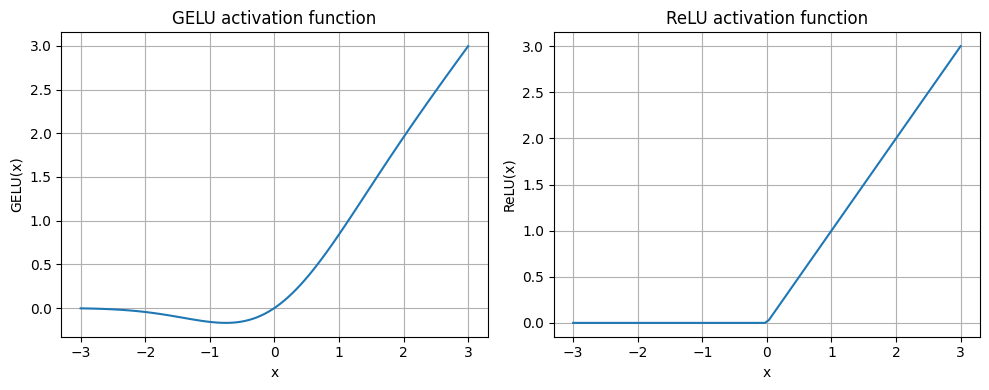

In [13]:
gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(10, 4))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-warning">

As we can see in the plot, GELU has several advantages over the standard ReLU function:

* **It's smooth:** Unlike ReLU, which has a sharp corner at zero, GELU is a smooth function.This can lead to better, more stable optimization properties during model training.
* **It's non-zero for negative values:** ReLU completely blocks any negative input by turning it to zero. GELU allows a small amount of negative information to pass through, which means neurons that receive negative input can still contribute to the learning process.
</div>

### 3.5.2 Building the `FeedForward` Module

<div class="alert alert-block alert-success">
    
Now, let's use our `GELU ` activation to build the `FeedForward` module. A key feature of the transformer's feed-forward layer is that  it first **expands** the input embedding dimension (typically by a factor of 4) and then **contracts** it back down. This expand-and-contract design allows the model to learn richer, more complex representations for each token in a higher-dimensional space.
</div>

In [13]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), #Expansion layer
            GELU(), # Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), # Contraction layer
        )

    def forward(self, x):
        return self.layers(x)

### 3.5.3 Testing the `FeedForward` Module

<div class="alert alert-block alert-success">
    
Let's test out `FeedForward` module by passing a sample batch of data through it and verifying that the output shape is the same, as expected.

</div>

In [15]:
# Note: We can use the GPT_CONFIG_124M dictionary we defined earlier in the notebook

ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 4, 768)  # A sample batch: (batch_size, num_tokens, emb_dim)
out = ffn(x)

print("Input shape:", x.shape)
print("Output shape:", out.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


<div class="alert alert-block alert-info">
    
The uniformity in input and output dimensions (`[2, 4, 768]`) is a crucial design choice. It simplifies the overall GPT architecture by enabling multiple `TransformerBlock` layers to be stacked on top of each other seamlessly, without the need to adjust tensor dimensions between them.
</div>

## 3.6 The GPT Architecture IV: Shortcut Connections

<div class="alert alert-block alert-success">
    
A critical innovation that enabled the training of very deep neural networks is the **shortcut** or **residual connection**. This technique helps to mitigate the "vanishing gradient problem", a common issue where the signal from the loss function becomes too weak to update the weights in the early layers of a deep network.

In a transformer block, shortcut connections are used around both the self-attention and the feed-forward layers. Let's see why they are so important with a hands-on example.
</div>

### 3.6.1 The Vanishing Gradient Problem

<div class="alert alert-block alert-success">
    
To understand the problem, we'll first build a simple, deep neural network **without** shortcut connections. We will then perform a backward pass and observe the gradients diminish as they flow from the final layer back to the first.
</div>

In [16]:
# A simple deep network and a helper function to inspect gradients
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[i], layer_sizes[i+1]), GELU())
            for i in range(len(layer_sizes) - 1)
        ])
    
    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            # Add shortcut connection if enable and shapes match
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

def print_gradients(model, x):
    """A helper function to compute and print the mean absolute gradient for each layer's weights."""
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss (how far the output is from the target)
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to compute gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")
    

<div class="alert alert-block alert-success">
Now, let's create an instance of this network with shortcuts disabled and calculate the gradients for each layer.
</div>

In [17]:
torch.manual_seed(100)

layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])

model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

print_gradients(model_without_shortcut, sample_input)


layers.0.0.weight has gradient mean of 0.00011775017628679052
layers.1.0.weight has gradient mean of 0.0003875654365401715
layers.2.0.weight has gradient mean of 0.0014669443480670452
layers.3.0.weight has gradient mean of 0.001532275229692459
layers.4.0.weight has gradient mean of 0.013530432246625423


<div class="alert alert-block alert-info">
    
<b>Analysis: Vanishing Gradients</b><br>

As we can see in the output above, the mean gradient value is much larger for the last layer (`layers.4.0.weight`) than it is for the first layer (`layers.1.0.weight`). The gradient signal shrinks or "vanishes" as it is propagated backward through the network. In a much deeper network, the gradients for the initial layers would become so close to zero that those layers would effectively stop learning.
</div>

### 3.6.2 The Solution: Adding Shortcut Connections

<div class="alert alert-block alert-success">
    
Now, let's enable the shortcut connections. By simply setting `use_shortcut=True`, our `forward` method will add the input of each layer (`x`)  back to its output (`layer_output`). This creates a direct path for the gradient to flow backward through the network, bypassing the layers that can diminish it.

</div>

In [18]:
torch.manual_seed(100)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)

print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.08600781857967377
layers.1.0.weight has gradient mean of 0.44186362624168396
layers.2.0.weight has gradient mean of 0.10087182372808456
layers.3.0.weight has gradient mean of 0.250803679227829
layers.4.0.weight has gradient mean of 1.407089114189148


<div class="alert alert-block alert-info">
    
<b>Conclusion: Stable Gradients</b><br>

Success! With the shortcut connection enabled, the gradient values in the early layers are much stronger and on the same order of magnitude as the later layers. The gradient is able to flow effectively through the entire network.

This technique is a core building block of very large models like LLMs, as it facilitates more effective and stable training.
</div>

## 3.7 The GPT Architecture V: Assembling the Transformer Block

<div class="alert alert-block alert-success">

We have now built all the necessary components: `MultiHeadAttention`, `LayerNorm`, `FeedForward`, and we understand the importance of `Shortcut Connections`. It is finally time to assemble them into a complete `TransformerBlock`.

This block is the fundamental, repeating unit of the GPT model. The model's power comes from stacking many of these blocks on top of each other.

</div>

### 3.7.1 Defining the `TransformerBlock` Class

<div class="alert alert-block alert-success">
    
The `TransformerBlock` class combines the two main sub-layers (*multi-head attention* and the *feed-forward network*). Crucially, it applies `LayerNorm` **before** each sub-layer and uses shortcut connections **after** each one. This "pre-layer norm" architecture is a modern design that leads to more stable training than the original transformer paper's "post-layer norm" approach.
</div>

In [15]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        
        # First sub-layer: Multi-Head Attention
        self.attn = MultiHeadAttention(
        d_in=cfg["emb_dim"],
        d_out=cfg["emb_dim"],
        context_length=cfg["context_length"],
        num_heads=cfg["n_heads"],
        dropout_rate=cfg["dropout_rate"],
        qkv_bias=cfg["qkv_bias"])

        # Second sub-layer: Feed-Forward Network
        self.ff = FeedForward(cfg)

        # Layer normalization for each sub-layer
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])

        # Dropout for the shortcut connection
        self.drop_shortcut = nn.Dropout(cfg["dropout_rate"])

    def forward(self, x):
        # --- Attention Block with Shortcut Connection ---
        shortcut = x
        x_norm = self.norm1(x)
        attn_output = self.attn(x_norm)
        x = shortcut + self.drop_shortcut(attn_output)

        # --- Feed-Forward Block with Shortcut Connection ---
        shortcut = x
        x_norm = self.norm2(x)
        ff_output = self.ff(x_norm)
        x = shortcut + self.drop_shortcut(ff_output)

        return x

### 3.7.2 Testing the Block

<div class="alert alert-block alert-success">
    
Now, let's instantiate our `TransformerBlock` and pass a sample batch of data through it to verify that it maintains the input shape, as expected.
</div>

In [20]:
torch.manual_seed(100)

# Create a sample input batch: (batch_size, num_tokens, emb_dim)
x = torch.rand(2, 4, GPT_CONFIG_124M["emb_dim"])

block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## 3.8 Final Assembly: The Complete `GPTModel`

<div class="alert alert-block alert-success">
    
With the `TransformerBlock` now fully defined, we have the last and most important building block. We can now assemble all of our components -the *embeddings*, the *stack of transformer blocks*, and the final *output layers*- into the complete `GPTModel` architecture.
</div>

### 3.8.1 Defining the `GPTModel` Class

In [8]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["dropout_rate"])

        # A sequential stack of Transformers
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

<div class="alert alert-block alert-success">
    
The `GPTModel` class uses its `__init__` constructor to build the layers of the network based on the provided configuration (`cfg`):

* **Embedding Layers:** It initializes `tok_emb` and `pos_emb` layers. These are responsible for comverting input token IDs into vectors and adding positional information. A `dropout` layer (`drop_emb`) is also initialized for regularization.

* **Transformer Blocks:** It creates a sequential stack of the `TransformerBlock` modules we built previously. The number of blocks is determined by `n_layers` in the configuration dictionary.

* **Final Layers:** A final `LayerNorm` is applied for stability, followed by a linear `out_head` layer. This output head projects the transformer's output back into the vocabulary space to generate a score for every possible token.


The **forward** method then defines the data's journey through these layers, taking token IDs as input and producing the final `logits` (the raw scores for the next-token prediction.
</div>

<div class="alert alert-block alert-success">
We will convert these logits into tokens and text outputs in the next section.
</div>

### 3.8.2 Testing the Full Model

<div class="alert alert-block alert-success">
    
Let's now instantiate our complete `GPTModel` using the `GPT_CONFIG_124M` dictionary and feed it the sample batch we created earlier. This will verify that the data flows through the entire stack of components correctly and produces an output of the expected shape.
</div>

In [20]:
torch.manual_seed(100)
model = GPTModel(GPT_CONFIG_124M)

out = model (batch)

print("Input batch shape:", batch.shape)
print("\nOutput batch shape:", out.shape)

Input batch shape: torch.Size([2, 4])

Output batch shape: torch.Size([2, 4, 50257])


<div class="alert alert-block alert-success">
    
As we can see, the output tensor has the shape `[2, 4, 50257]`, since we passed in 2 input texts with 4 tokens each. The final dimension, 50,257, correctly corresponds to the vocabulary size of the tokenizer.
</div>

### 3.8.3 Analyzing the Parameter Count

<div class="alert alert-block alert-success">
    
Now, let's see how large our model is by calculating its total number of parameters using the `.numel()` method, which is short for "number of elements".
</div>

In [23]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


<div class="alert alert-block alert-info">
    
<b>Why 163M Parameters Instead of 124M? A Note on Weight Tying</b><br>
You might wonder why our model has 163 million parameters, while the GPT-2 model we're basing it on is famous for having 124 million. The reason is a concept called <b>weight tying</b>.

The original GPT-2 architecture re-used the weights from the token embedding layer (`tok_emb`) as its final output layer (`out_head`). This saves a significant number of parameters. Our `GPTModel` uses separate weights for each, which is a more modern and often better-performing practice.

If we subtract the parameters from our output head, we arrive at the original GPT-2 number.
    
    
</div>

In [26]:
# Verify the shapes of the layers
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

# Calculate the parameter count without the final output layer
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"\nNumber of parameters considering weight tying: {total_params_gpt2:,}")

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])

Number of parameters considering weight tying: 124,412,160


### 3.8.4 Calculating Memory Footprint

<div class="alert alert-block alert-success">
    
Finally, let's see how much memory these 163 million parameters wwill occupy. Assuming each parameter is a standard 32-bit float (which takes up 4 bytes), we can calculate the model's size.
</div>

In [27]:
# Each parameter is a 32-bit float (4 bytes)
total_size_bytes = total_params * 4

# Convert bytes to megabytes (1 MB = 1024 * 1024 bytes)
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


<div class="alert alert-block alert-success">
The total size of over 600 MB illustrates the significant storage and memory capacity required to accommodate even relatively small LLMs like this one.
</div>

# Chapter 3 Summary and Next Steps

This marks the end of our journey in building a complete GPT model architecture from scratch. We have successfully progressed from the most fundamental concepts of self-attention to assembling a full, functional language model, ready for training.

<div class="alert alert-block alert-success">
  <b>Congratulations on This Major Accomplishment!</b><br>
  Throughout these notebooks, we have:
  <ul>
    <li>Implemented the core <b>self-attention mechanism</b> from first principles.</li>
    <li>Built essential layers like <b>LayerNorm</b>, <b>GELU</b>, and position-wise <b>Feed-Forward Networks</b>.</li>
    <li>Scaled up our attention with a professional <b>Multi-Head Attention</b> module.</li>
    <li>Assembled all these components into the fundamental, repeating <b>Transformer Block</b>.</li>
    <li>Constructed the final <b>`GPTModel`</b>, capable of taking token IDs as input and producing logits as output.</li>
  </ul>
</div>

### Where We Are Now
We have a complete, architecturally correct GPT model with randomly initialized weights. As we saw in the text generation step, this untrained model produces incoherent gibberish. This is the expected and correct state at this stage. The "brain" has been built, but it has not yet learned anything.

### What Are the Next Steps?
Building the architecture is a huge part of the challenge, but the journey to a powerful LLM continues. The next logical steps would be:
* **Training the Model:** Implementing a training loop that feeds the model large amounts of text data, calculates a loss (using cross-entropy), and updates the model's weights via an optimizer like AdamW.
* **Scaling Up:** Training a model with more layers, more attention heads, and a larger embedding dimension on a massive dataset (many gigabytes of text), likely on GPU hardware.
* **Improving Text Generation:** Implementing more sophisticated sampling techniques beyond simple `argmax` (greedy decoding), such as temperature sampling or nucleus sampling, to generate more creative and diverse text.
* **Evaluation:** Establishing metrics like perplexity to objectively measure how well the model has learned the language after training.

Thank you for following along on this deep dive. Understanding these models from the ground up provides a powerful foundation for working with and building upon any language model in the field.